In [1]:
import numpy as np
import functions as fc
import fourier_continuation as fc_c
from timeit import default_timer as time
from fatiando.gravmag import polyprism, sphere
from fatiando import mesher, gridder,utils
from fatiando.constants import G, SI2MGAL
from scipy.sparse import diags
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from scipy import interpolate
from fatiando.vis import mpl
import cPickle as pickle
%matplotlib inline

/home/vanderlei/Documents/fatiando/fatiando/vis/mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Open data and configuration

In [2]:
with open('synthetic_gz.pickle') as r:
    synthetic_gz = pickle.load(r)
    
xi = synthetic_gz['x']
yi = synthetic_gz['y']
zi = synthetic_gz['z']
zi_up = synthetic_gz['z_up']
zi_down = synthetic_gz['z_down']
dobs = synthetic_gz['gz_low']
dobs_up = synthetic_gz['gz_up']
dobs_down = synthetic_gz['gz_down']

shape = (100, 100)
area = [-5000, 5000, -4000, 4000]
R = 1000
xc, yc = -3000, 0

## Equivalent Layer Depth

In [3]:
# Equivalent Layer depth
zj = np.ones_like(zi)*300

## Fast Eq. Layer

In [4]:
# Predicted data
itmax = 40
s = time()
rho, gzp = fc.fast_eq(xi,yi,zi,zj,shape,dobs,itmax)
e = time()
tcpu = e - s
print tcpu, 'seconds'

10.7109000683 seconds


## Fast Eq. Layer BCCB

In [5]:
# Predicted data
itmax = 40
s = time()
rho_c, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,dobs,itmax)
e = time()
tcpu = e - s
print tcpu, 'seconds'

0.235253095627 seconds


## Upward Continuation and Downward Continuation

In [6]:
N = shape[0]*shape[1]

#up BCCB
s = time()
#zi_up = np.ones_like(zi)*-300
BTTB_up = fc.bttb(xi,yi,zi_up,zj)
cev_up = fc.bccb(shape,N,BTTB_up)
gzp_bccb_up = fc.fast_forward_bccb(shape,N,rho_c,cev_up)
e = time()
tcpu = e - s
print tcpu, 'seconds'

s = time()
A = fc.sensibility_matrix(xi,yi,zi_up,zj,N)
gzp_up = A.dot(rho)
e = time()
tcpu = e - s
print tcpu, 'seconds'


#down BCCB
s = time()
#zi_down = np.ones_like(zi)*-50
BTTB_down = fc.bttb(xi,yi,zi_down,zj)
cev_down = fc.bccb(shape,N,BTTB_down)
gzp_bccb_down = fc.fast_forward_bccb(shape,N,rho_c,cev_down)
e = time()
tcpu = e - s
print tcpu, 'seconds'

s = time()
A = fc.sensibility_matrix(xi,yi,zi_down,zj,N)
gzp_down = A.dot(rho)
e = time()
tcpu = e - s
print tcpu, 'seconds'

0.00461721420288 seconds
8.80999398232 seconds
0.00404715538025 seconds
9.29534888268 seconds


### Upward plot

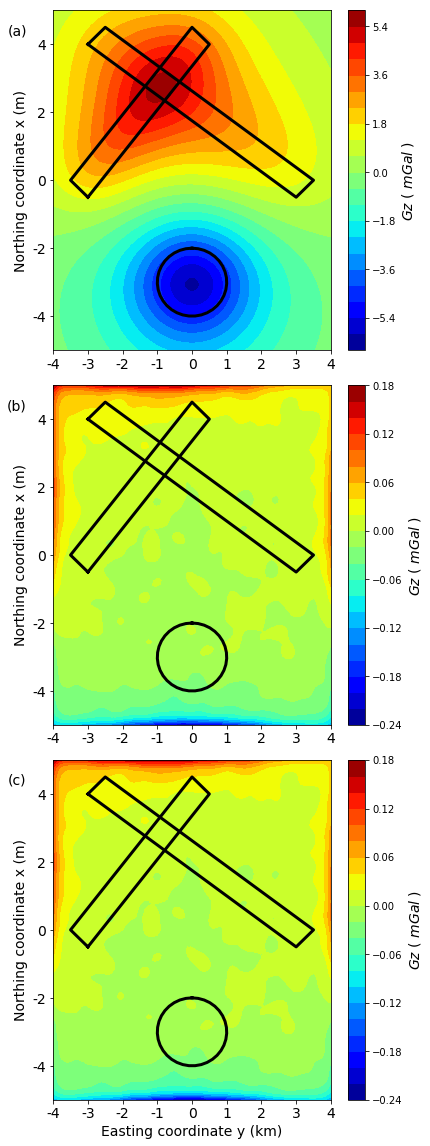

In [7]:
#Projection_model
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc + R*np.cos(phi)
y = yc + R*np.sin(phi)

x_p = [-3000., -3500, 0, 500, -3000.]
y_p = [-500., 0, 4500, 4000, -500.]

x_p2 = [-3000, -2500, 3500, 3000, -3000.]
y_p2 = [4000, 4500, 0, -500, 4000]

plt.figure(figsize=(6,16))

plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_up,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_up = dobs_up-gzp_up
plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_up,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_bccb_up = dobs_up-gzp_bccb_up
plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_bccb_up,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/upward_low.png', dpi=300)

In [8]:
mean = np.mean(delta_gz_up)
print mean
std = np.std(delta_gz_up)
print std
mean = np.mean(delta_gz_bccb_up)
print mean
std = np.std(delta_gz_bccb_up)
print std

0.003130823429784544
0.03406492859767435
0.0031308234297844103
0.034064928597674196


### Downward plot

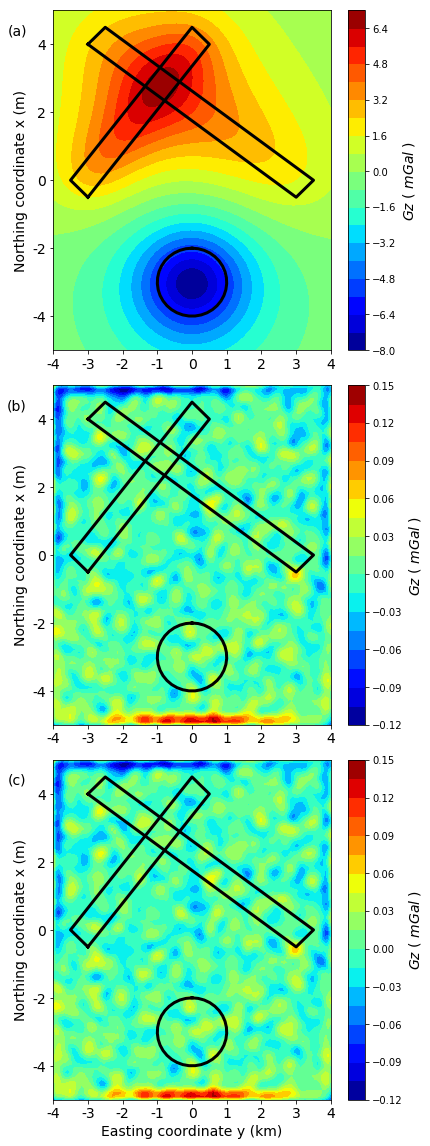

In [9]:
plt.figure(figsize=(6,16))

plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_down = dobs_down-gzp_down
plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_bccb_down = dobs_down-gzp_bccb_down
plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_bccb_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/downward_low.png', dpi=300)

In [10]:
mean = np.mean(delta_gz_down)
print mean
std = np.std(delta_gz_down)
print std
mean = np.mean(delta_gz_bccb_down)
print mean
std = np.std(delta_gz_bccb_down)
print std

-0.0010081889321025945
0.023847125375068397
-0.0010081889321024442
0.02384712537506831


## Comparison Upward - BCCB vs. Fast vs. Fourier

In [11]:
# Up Fourier
gzp_fourier_up = fc_c.upcontinue(xi, yi, dobs, shape, 200)

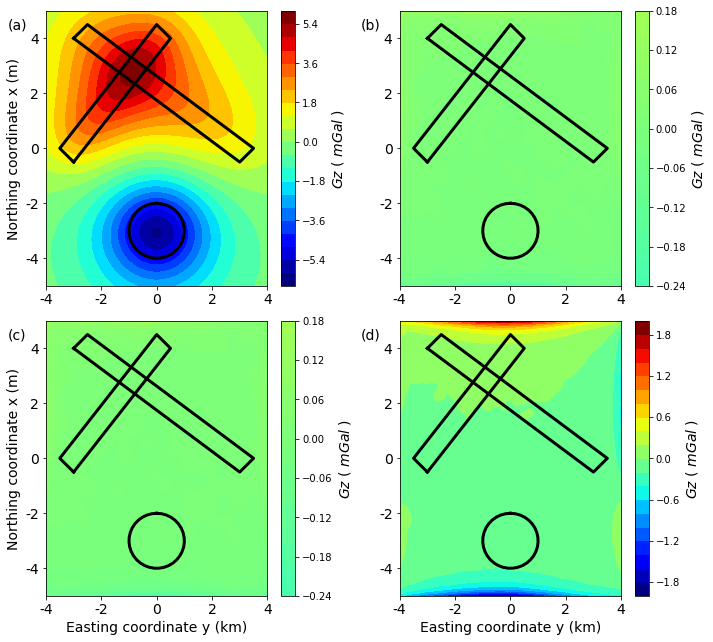

In [17]:
plt.figure(figsize=(10,9))

delta_gz_fourier_up = dobs_up-np.ravel(gzp_fourier_up)

# define the scale for residuals
scale_max = np.max([delta_gz_bccb_up, delta_gz_up, delta_gz_fourier_up])
scale_min = np.min([delta_gz_bccb_up, delta_gz_up, delta_gz_fourier_up])

plt.subplot(221)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_up,22,cmap='jet', vmin = np.min(dobs_up), vmax = np.max(dobs_up))
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(222)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_bccb_up,22,cmap='jet', vmin = scale_min, vmax = scale_max)
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(223)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_up,22,cmap='jet', vmin = scale_min, vmax = scale_max)
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(224)
plt.title('(d)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_fourier_up,22,cmap='jet', vmin = scale_min, vmax = scale_max)
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.tight_layout(True)
plt.savefig('../manuscript/Fig/upward_fourier_low.png', dpi=300)

In [13]:
print np.std(delta_gz_bccb_up)
print np.std(delta_gz_up)
print np.mean(delta_gz_fourier_up)
print np.std(delta_gz_fourier_up)

0.034064928597674196
0.03406492859767435
-0.029923731916596814
0.262191673217383


## Comparison Downward - BCCB vs. Fast vs. Fourier

In [14]:
gzp_fourier_down = fc_c.upcontinue(xi, yi, dobs, shape, -50)

fourier_continuation.py:57: UserWarning: Using 'height' <= 0 means downward continuation, which is known to be unstable.
  "which is known to be unstable.")


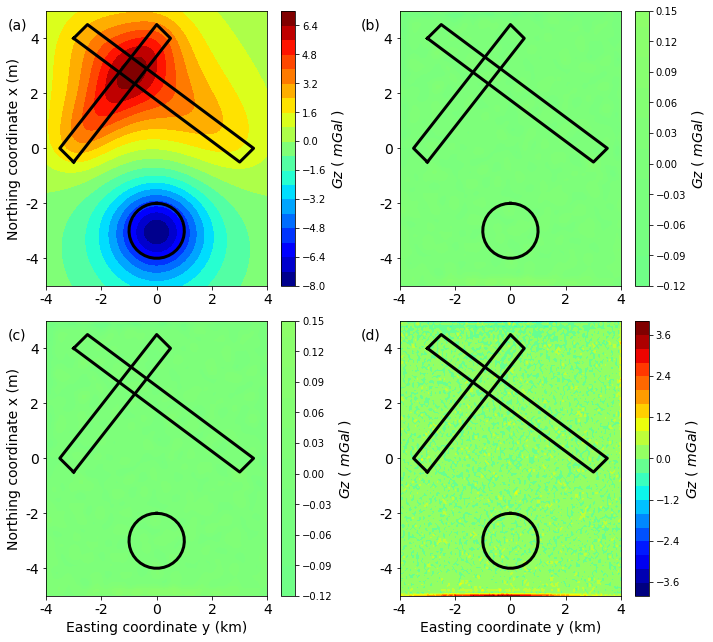

In [15]:
plt.figure(figsize=(10,9))

delta_gz_fourier_down = dobs_down-np.ravel(gzp_fourier_down)

# define the scale for residuals
scale_max = np.max([delta_gz_bccb_down, delta_gz_down, delta_gz_fourier_down])
scale_min = np.min([delta_gz_bccb_down, delta_gz_down, delta_gz_fourier_down])

plt.subplot(221)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_down,22,cmap='jet', vmin = np.min(dobs_down), vmax = np.max(dobs_down))
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(222)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_bccb_down,22,cmap='jet', vmin = scale_min, vmax = scale_max)
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(223)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_down,22,cmap='jet', vmin = scale_min, vmax = scale_max)
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(224)
plt.title('(d)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_fourier_down,22,cmap='jet', vmin = scale_min, vmax = scale_max)
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.tight_layout(True)
plt.savefig('../manuscript/Fig/downward_fourier_low.png', dpi=300)

In [16]:
print np.std(delta_gz_bccb_down)
print np.std(delta_gz_down)
print np.mean(delta_gz_fourier_down)
print np.std(delta_gz_fourier_down)

0.02384712537506831
0.023847125375068397
0.007934556974675246
0.4048078919583258
